<a href="https://colab.research.google.com/github/Tomawock/MLDM_COVID-19/blob/master/decisionTree/covid_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID RANDOM FOREST

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 8)

import joblib
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import r2_score, mean_squared_error, max_error
from sklearn.ensemble import RandomForestRegressor 

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

import pydotplus
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os
os.chdir("/content/drive/Shared drives/MLDM progetto/Datasets/dataset_finali")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### MODELLO: preparazione dei datasets

**Carichiamo** il dataset ed impostiamo il **random state**. Trasformiamo l'attributo nominale in numerico.

**Dividiamo** il dataset in:
* **training** set
* **testing** set

Proviamo utilizzando l'**80%** dei records per il training set ed il restante per il testing.

In [7]:
df_2 = pd.read_csv("dataset_finale_medie_2_week_rnd1.csv", parse_dates=["Data"], infer_datetime_format=True)
df_0 = pd.read_csv("dataset_finale_medie_rnd1.csv", parse_dates=["Data"], infer_datetime_format=True)

rnd_state = 12
predictor_columns = [
                     'pass_Ammoniaca', 
                     'pass_Benzene',
       'pass_Biossido di Azoto', 
       'pass_Biossido di Zolfo',
       'pass_Monossido di Azoto', 
       'pass_Monossido di Carbonio',
       'pass_Ossidi di Azoto', 
       'pass_Ozono', 
       'pass_PM10 (SM2005)',
       'pass_Particelle sospese PM2.5',
       'pass_Radiazione Globale', 
       'pass_Temperatura',
       'pass_deceduti',
       'pass_nuovi_positivi',
       'pass_ricoverati_con_sintomi', 
       'pass_tamponi']


**Prepariamo** il **training** set ed il **test** set per il data set relativo all'interllo fra i **quattordici e sette giorni precedenti**



In [8]:
train_2 = df_2.sample(frac=0.70, random_state=rnd_state)
test_2 = df_2.drop(train_2.index)

train_X_2 = train_2[predictor_columns]
train_y_2 = train_2["fut1_nuovi_positivi"]

test_X_2 = test_2[predictor_columns]
test_y_2 = test_2["fut1_nuovi_positivi"]

**Prepariamo** il **training** set ed il **test** set per il data set relativo all'interllo dei **quattordici giorni precedenti**


In [9]:
train_0 = df_0.sample(frac=0.70, random_state=rnd_state)
test_0 = df_0.drop(train_0.index)

train_X_0 = train_0[predictor_columns]
train_y_0 = train_0["fut1_nuovi_positivi"]

test_X_0 = test_0[predictor_columns]
test_y_0 = test_0["fut1_nuovi_positivi"]

### MODELLO: training ###

Creiamo il **regressore** basato su alberi di decisione.

In [10]:
# create regressor object 
forest_regressor = RandomForestRegressor(bootstrap=False) 

Definiamo la **Pipeline**, come abbiamo fatto per le ANN:
* imputer
* addestramento del modello

In [11]:
pipeline = Pipeline([("imp", SimpleImputer(missing_values=np.nan, strategy="mean")), 
                     ("clf", forest_regressor)])

In [12]:
imp=SimpleImputer(missing_values=np.nan, strategy="mean")
imp=imp.fit(train_X_2)

Prepariamo gli **iper-parametri** per la grid search.

In [13]:
#n_estimators_list = [100,150,50]
criterion_list = ["mse", "mae"]
max_depth_list = [None, 5, 6]
min_samples_split_list = [2, 3]
min_samples_split_leaf_list = [3,5]
min_weight_fraction_leaf_list = [0.0, 0.1]
max_features_list = ["auto", "sqrt", "log2"]
max_leaf_nodes_list = [None, 10, 25]
min_impurity_decrease_list = [0.0, 0.1]

param_grd = {"criterion": criterion_list,
              "max_depth": max_depth_list,
              "min_samples_split": min_samples_split_list,
              "min_samples_leaf": min_samples_split_leaf_list,
              "min_weight_fraction_leaf": min_weight_fraction_leaf_list,
              "max_features": max_features_list,
              "max_leaf_nodes": max_leaf_nodes_list,
              "min_impurity_decrease": min_impurity_decrease_list}

In [14]:
forest_regressor.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

**Addestriamo** il regressore mediante **grid search** e **k-fold** cross validation. Anche questa volta, utilizziamo k non superiore a 5 in modo da avere degli insiemi statisticamente significativi (con almeno 30 elementi).

Relativo fra **quattordici e sette giorni precedenti**


In [15]:
kfold_splits = 4
grid_regressor_2 = GridSearchCV(forest_regressor, param_grd, 
                              n_jobs=-1, 
                              verbose=1,
                              cv=5)



In [16]:
grid_regressor_2.fit(imp.transform(train_X_2), train_y_2)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  8.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, ran...
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [None, 5, 6]

Relativo ai **quattordici giorni precedenti**


In [17]:
kfold_splits = 4
grid_regressor_0 = GridSearchCV(forest_regressor, param_grd, 
                              n_jobs=-1, 
                              verbose=1,
                              cv=5)

grid_regressor_0.fit(train_X_0, train_y_0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  8.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, ran...
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [None, 5, 6]

### MODELLO: testing ###

Processiamo i dati di test allo stesso modo del training e procediamo alla fase di testing del **miglior regressore**, addestrato mediante grid search.

In [18]:
best_regressor_2 = grid_regressor_2.best_estimator_

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X_2)
test_X_imp = imputer.transform(test_X_2)

predicted_2 = best_regressor_2.predict(test_X_imp)

In [19]:
best_regressor_0 = grid_regressor_0.best_estimator_

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X_0)
test_X_imp = imputer.transform(test_X_0)

predicted_0 = best_regressor_0.predict(test_X_imp)

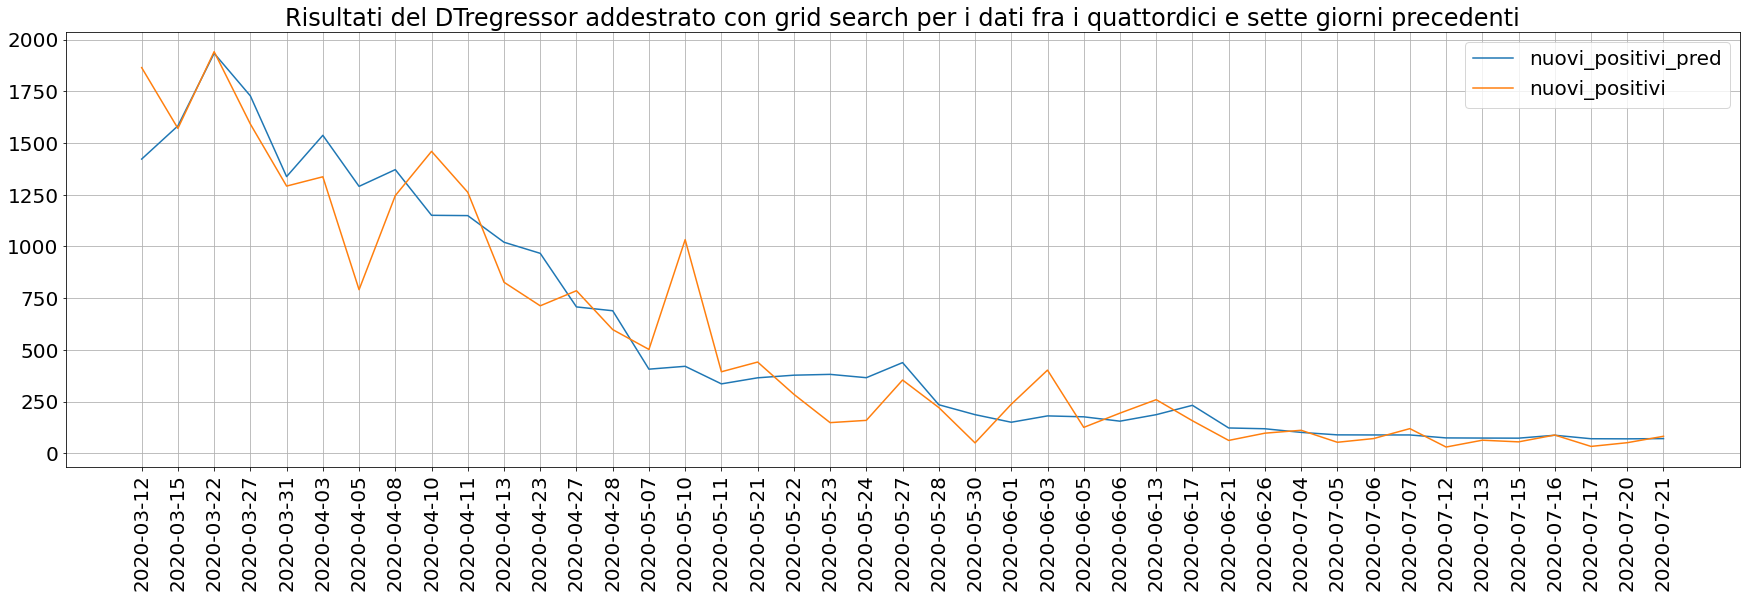

In [95]:
x_triks=df_2.loc[list(test_X_2.index),['Data']]
plt.rcParams.update({'font.size': 20})
plt.plot(predicted_2, label="nuovi_positivi_pred")
plt.plot(test_y_2.values, label="nuovi_positivi")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks['Data'].dt.date), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati del DTregressor addestrato con grid search per i dati fra i quattordici e sette giorni precedenti")
plt.show()

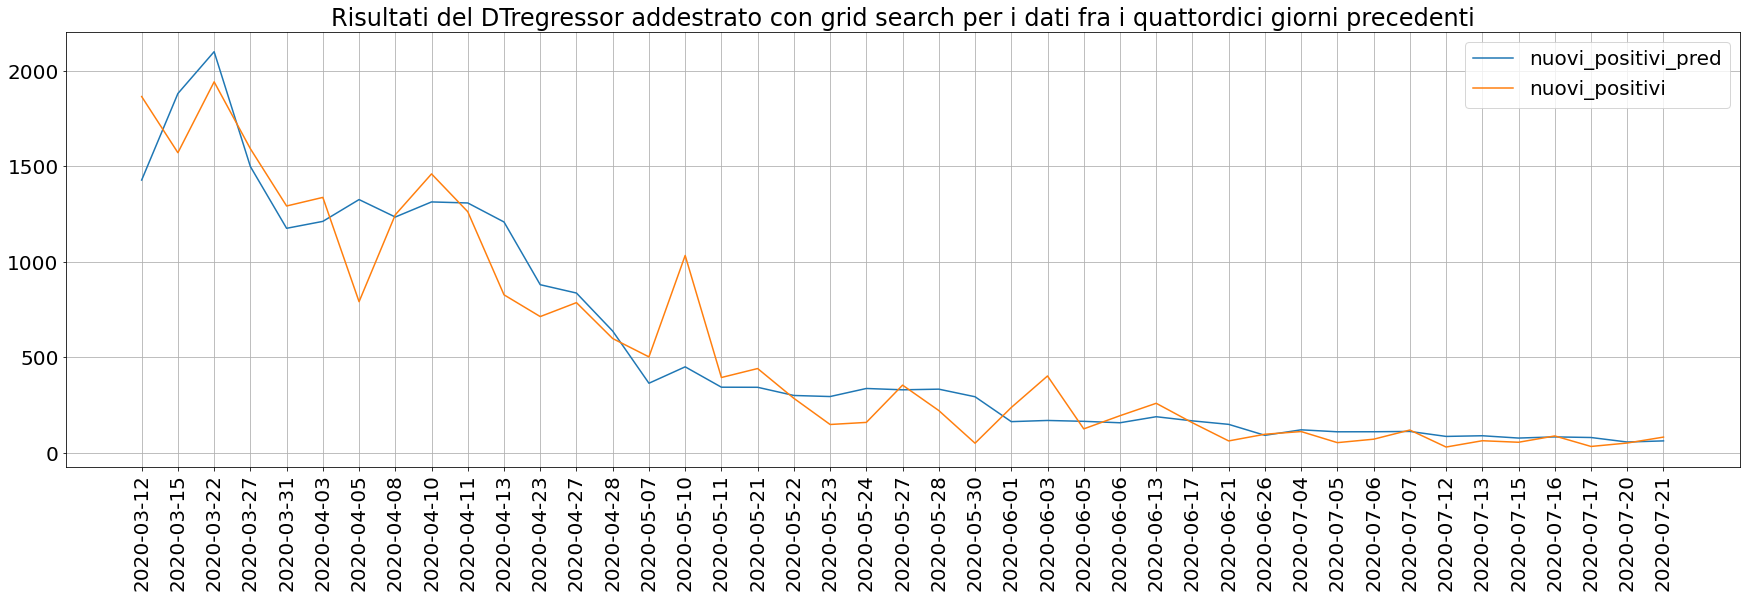

In [96]:
x_triks=df_0.loc[list(test_X_0.index),['Data']]
plt.rcParams.update({'font.size': 20})
plt.plot(predicted_0, label="nuovi_positivi_pred")
plt.plot(test_y_0.values, label="nuovi_positivi")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks['Data'].dt.date), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati del DTregressor addestrato con grid search per i dati fra i quattordici giorni precedenti")
plt.show()

### MODELLO: valutazione ed osservazioni ###

Vediamo le **caratteristiche** del miglior albero di decisione trovato.

In [22]:
best_regressor_2

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.1,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [23]:
best_regressor_0

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.1,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Si tratta di un DecisionTreeRegressor con splitter **random** e criterio di split **MAE** (Mean Absolute Error)

Calcoliamo alcune **misure di performance** per il regressore basato su alberi di decisione. Abbiamo scelto quelle a parer nostro più significative:
* **R2**: coefficiente di determinazione
* **RMSE**: root mean squared error
* **MAX Error**: errore massimo

Relativo fra **quattordici e sette giorni precedenti**


In [24]:
print(f"R2: \t\t{r2_score(test_y_2, predicted_2):.3}")
print(f"RMSE: \t\t{mean_squared_error(test_y_2, predicted_2, squared=False):.3}")
print(f"MAX ERR: \t{max_error(test_y_2, predicted_2)}")

R2: 		0.901
RMSE: 		1.77e+02
MAX ERR: 	612.5671111111111


Relativo ai **quattordici giorni precedenti**


In [25]:
print(f"R2: \t\t{r2_score(test_y_0, predicted_0):.3}")
print(f"RMSE: \t\t{mean_squared_error(test_y_0, predicted_0, squared=False):.3}")
print(f"MAX ERR: \t{max_error(test_y_0, predicted_0)}")

R2: 		0.896
RMSE: 		1.82e+02
MAX ERR: 	583.1139999999998


Possiamo **osservare** che le performance del miglior albero di decisione trovato sono abbastanza **buone**.

**R2** è **0.893**, ampiamente superiore a 0.5 ed abbastanza vicino al massimo (1). Questo vuol dire che il modello spiega gran parte della varianza dei dati.

**RMSE** è **59.7**, pertanto il nostro modello in media sbaglia il conteggio dei nuovi positivi di 60 unità. Seppur di primo acchitto sembri eccessivo, in realtà non lo è se si pensa che in alcune giornate sono stati registrati più di 1000 nuovi positivi.

**MAX ERR** è **238**. Dal grafico si nota come in un preciso giorno il predittore sbagli parecchio. Questo errore molto pronunciato va ad influenzare negativamente l'RMSE.

### MODELLO: feature importance

Visualizziamo la **feature importance** derivante dal training del miglior albero regressore.

Relativo fra **quattordici e sette giorni precedenti**


In [27]:
feature_importance = dict(zip(predictor_columns, best_regressor_2.feature_importances_))

for w in sorted(feature_importance, key=feature_importance.get, reverse=True):
    print(w, feature_importance[w])

pass_deceduti 0.20505518456991953
pass_Benzene 0.17381542254805943
pass_tamponi 0.14368181431057242
pass_Temperatura 0.12814437830112144
pass_Particelle sospese PM2.5 0.07809768614197315
pass_Monossido di Carbonio 0.06806386982585436
pass_Ozono 0.04808654770056524
pass_ricoverati_con_sintomi 0.03510754176516231
pass_Radiazione Globale 0.03361072887103185
pass_nuovi_positivi 0.022030628887528145
pass_Ossidi di Azoto 0.014642057907902127
pass_Ammoniaca 0.014565406261330792
pass_PM10 (SM2005) 0.014336057944291975
pass_Monossido di Azoto 0.013575478045333203
pass_Biossido di Zolfo 0.0037528584379807723
pass_Biossido di Azoto 0.0034343384813731877


Relativo ai **quattordici giorni precedenti**


In [28]:
feature_importance = dict(zip(predictor_columns, best_regressor_0.feature_importances_))

for w in sorted(feature_importance, key=feature_importance.get, reverse=True):
    print(w, feature_importance[w])

pass_Benzene 0.17332677250499734
pass_Particelle sospese PM2.5 0.1562622651070255
pass_deceduti 0.13441070250409098
pass_tamponi 0.13011872122934923
pass_Temperatura 0.11089459613979248
pass_Ossidi di Azoto 0.07335914910288412
pass_Monossido di Carbonio 0.06862624659922846
pass_PM10 (SM2005) 0.036915757920480755
pass_nuovi_positivi 0.023151628313374837
pass_Ozono 0.021855949908582993
pass_Biossido di Azoto 0.02138603102814171
pass_ricoverati_con_sintomi 0.01949189618570808
pass_Monossido di Azoto 0.019132628490023312
pass_Biossido di Zolfo 0.006975055953985995
pass_Radiazione Globale 0.0030251709699438347
pass_Ammoniaca 0.0010674280423903578


La feature più importante per lo split è stata, senza sorpresa, **"nuovi_positivi_mean"**, ossia la media dei nuovi positivi nei 5 giorni precedenti rispetto al giorno di riferimento.

La vera sorpresa è stata la feature **"so2"**, al secondo posto per importanza, con grande distacco da tutte le altre. L'anidride solforosa sembra avere una **correlazione importante** con i nuovi positivi predetti.

Un'ultima osservazione interessante riguarda l'attributo **"region"**, che è quello meno importante di tutti. Ciò vuol dire che, con buona probabilità, il modello si comporterà bene anche con **altre zone geografiche**.